In [1]:
from rdkit import Chem
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import Atom, BondType

import numpy as np
import pandas as pd

In [2]:
def amat_entry(amat,r,c,val):
    """
    changes the (r,c) and (c,r) values of matrix "amat" to "val"
    """
    amat[r-1][c-1] = amat[c-1][r-1]= val
    return

In [3]:
def amat_edit(amat,r,c,delta):
    """
    changes the (r,c) and (c,r) values of matrix "amat" to "val"
    """
    amat[r-1][c-1] += delta
    if r != c:
        amat[c-1][r-1] += delta
    return

In [4]:
def molFromAdjMat(atoms, amat,sanitize=True):
    """Creates a mol object from an adjacency matrix.
    Inputs:
    atoms: list of atomic numbers of atoms, by row
    amat: adjacency matrix. Has to have same length as atoms (obviously)
    Output: mol object
    Might need to add a try clause for sanitize"""
    
    m = Chem.RWMol()
    # add in the separate atoms
    for a in atoms: m.AddAtom(Atom(a))
    side_len = len(amat)    
    for r in range(side_len):
        for c in range(r+1,side_len):
            bond_order = amat[r][c]
            if bond_order > 0:
                if bond_order == 1: m.AddBond(r,c,BondType.SINGLE)
                if bond_order == 2: m.AddBond(r,c,BondType.DOUBLE)
                if bond_order == 3: m.AddBond(r,c,BondType.TRIPLE)

    if sanitize:
        Chem.SanitizeMol(m)
    return m

In [5]:
def mol_with_atom_index(mol):
    for atom in mol.GetAtoms():
        atom.SetAtomMapNum(atom.GetIdx()+1)
    return mol

In [6]:
def make_changelogs(data_file_path):
    data = pd.read_csv(data_file_path)[["bond","edit","file"]]
    data = data[~data.bond.isnull()].copy()
    
    changelogs = []
    entry = {}
    bond_edits = ()
    for r in data.itertuples():


        # reset entry dict at new step
        if r[1] == "step":
            entry["edits"] = bond_edits
            changelogs.append(entry)
            entry = {}

        # if padding, fill th
        elif r[1] == "pad":
            pad_atoms = r[3].split(" ")
            pad_atoms = [int(i) for i in pad_atoms]

            if pad_atoms == [0]:
                entry["pad"] = 0
                entry["pad_elem"] = []

            else:
                entry["pad"] = len(pad_atoms)
                entry["pad_elem"] = pad_atoms

            # make the empty bond edits here to prepare
            bond_edits = []
        else:
            bond_edits.append((int(r[1]),int(r[2]),int(r[3])))
    
    return changelogs

In [7]:
def apply_changes(amat_init, atoms_init,changelogs):
    seq_out = [amat_init.copy()]
    amat = amat_init.copy()
    atoms = atoms_init.copy()
    for i in changelogs:
#         try:
            
        pad_amt = i["pad"]

        if pad_amt > 0:
            amat = np.pad(amat,[(0, pad_amt), (0, pad_amt)],  mode="constant")
            atoms.extend(i["pad_elem"])

        for ed in i["edits"]:
            amat_edit(amat,ed[0],ed[1],ed[2])
        seq_out.append(amat.copy())
            
#         except:
#             print(i)
        
    seq_out.reverse()
    
    all_sizes = [m.shape[0] for m in seq_out]
    max_size = max(all_sizes)

    output_padded = []

    for mat in seq_out:
        mat_size = mat.shape[0]
        if mat_size < max_size:
            pad_size = max_size - mat_size 
            output_padded.append(np.pad(mat, [(0, pad_size), (0, pad_size)], mode='constant'))
        else:
            output_padded.append(mat)
            
        
    return output_padded,atoms
    

## initialize

In [8]:
# start with stemoamide, to have better atom matching
stemo = Chem.MolFromSmiles("O=C([C@H]1C)O[C@@]2([H])[C@@]1([H])[C@]3([H])CCC(N3CCC2)=O")

stemo_atoms = [atm.GetAtomicNum() for atm in stemo.GetAtoms()]
stemo_symbs = [atm.GetSymbol() for atm in stemo.GetAtoms()]

amat = Chem.GetAdjacencyMatrix(stemo,useBO=True,force=True)
amat_init = Chem.GetAdjacencyMatrix(stemo,useBO=True,force=True)
amat_init = amat[:-1,:-1].copy()

In [9]:
# modify to make stemonine
amat_init = np.pad(amat_init,[(0, 7), (0, 7)],  mode="constant")

changes = [(11,16,1),(16,17,1),(16,20,1),(17,18,1),(18,22,1),(18,19,1),(19,21,2),(19,20,1)]

for c in changes:
    amat_entry(amat_init, *c)

stemo_atoms = stemo_atoms[:-1] + [6,6,6,6,8,8,6]

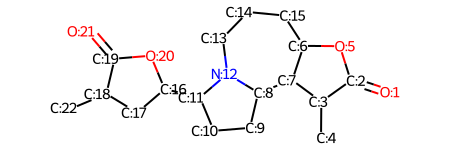

In [10]:
mol_with_atom_index(molFromAdjMat(stemo_atoms,amat_init))

### make the matrix


In [11]:
changelogs = make_changelogs("./edit_files/edits_stemonine_synthia.csv")

In [12]:
out_1,final_atoms_1 = apply_changes(amat_init, stemo_atoms,changelogs[1:])

In [13]:
from rdkit.Chem.Draw import *
for i in range( len(out_1)):
    print(i)
    m = molFromAdjMat(final_atoms_1,out_1[i],sanitize=False)
    Chem.SanitizeMol(m)
    print(Chem.MolToSmiles(m))

0
C.C=CC.CC(CO)CI.N#CCCCC=O.O.O.O=C(Cl)CO.O=C(O)CP
1
C.C=CC.CC(CO)CI.N#CCCC1C=CC(=O)O1.O.O.O.O=C(Cl)CO.P
2
C.C=CC.CC(CO)CI.NCCCC1C=CC(=O)O1.O.O.O.O=C(Cl)CO.P
3
C=CCC1C(CCCN)OC(=O)C1C.CC(CO)CI.O.O.O.O=C(Cl)CO.P
4
C=CC(=O)C1C(CCCN)OC(=O)C1C.CC(CO)CI.O.O.O=C(Cl)CO.P
5
C=CC(=O)C1C(CCCN)OC(=O)C1C.CC(CO)CC(O)C=O.Cl.I.O.O.P
6
C=CC(=O)C1C(CCCN)OC(=O)C1C.CC1CC(C=O)OC1=O.Cl.I.O.O.P
7
CC1CC(C(=O)CCC(=O)C2C(CCCN)OC(=O)C2C)OC1=O.Cl.I.O.O.P
8
CC1CC(C(O)CCC(O)C2C(CCCN)OC(=O)C2C)OC1=O.Cl.I.O.O.P
9
CC1CC(C2CCC3C4C(CCCN23)OC(=O)C4C)OC1=O.Cl.I.O.O.O.O.P
10
CC1CC(C2CCC3C4C(CCCN23)OC(=O)C4C)OC1=O.Cl.I.O.O.O.O.P


In [14]:
save_dict = {"amats":out_1[:-1],"atoms":final_atoms_1}

np.savez("./matrices/stemonine_synthia",**save_dict)